In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)
random.seed(0)

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [171]:
pd.set_option('display.max_colwidth', None)
stock_data_df = pd.read_csv('stock_data.csv')
stock_data_df

,Text,Sentiment
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,"Industry body CII said #discoms are likely to suffer a net revenue loss of around Rs 30,000 crore\n\nhttps://t.co/8c6YJYJajL",-1
5787,"#Gold prices slip below Rs 46,000 as #investors book profits amid #coronavirus-led #recession fears https://t.co/fSylAJrUqv",-1
5788,Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI",1


In [172]:
pd.set_option('display.max_colwidth', None)
stock_data_df

,Text,Sentiment
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,"Industry body CII said #discoms are likely to suffer a net revenue loss of around Rs 30,000 crore\n\nhttps://t.co/8c6YJYJajL",-1
5787,"#Gold prices slip below Rs 46,000 as #investors book profits amid #coronavirus-led #recession fears https://t.co/fSylAJrUqv",-1
5788,Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI",1


In [173]:
stock_data_df['Sentiment'] = stock_data_df['Sentiment'].replace({-1: 0})

In [174]:
def preprocess_text(text):

  # lower case everything
  text = text.lower()



  text = re.sub(r'#','',text)
  text = re.sub(r'https?://t\.co/\S+', '', text)


  # tokenize the text
  tokens = word_tokenize(text)

  # remove stop words that aren't useful
  stop_words = set(stopwords.words('english'))
  stop_words = stop_words - {'over'}

  tokens = [word for word in tokens if word not in stop_words]

  # conjoin separated texts to run through vectorizer
  return ' '.join(tokens)


In [175]:
stock_data_df['Text'] = stock_data_df['Text'].apply(lambda x: preprocess_text(x))
stock_data_df

,Text,Sentiment
0,"kickers watchlist xide tit soq pnk cpw bpz aj trade method 1 method 2 , see prev posts",1
1,user : aap movie . 55 % return fea/geed indicator 15 trades year . awesome .,1
2,user 'd afraid short amzn - looking like near-monopoly ebooks infrastructure-as-a-service,1
3,mnta over 12.00,1
4,oi over 21.37,1
...,...,...
5786,"industry body cii said discoms likely suffer net revenue loss around rs 30,000 crore",0
5787,"gold prices slip rs 46,000 investors book profits amid coronavirus-led recession fears",0
5788,workers bajaj auto agreed 10 % wage cut period april 15 till lockdown lifted .,1
5789,"sharemarket live : sensex day ’ high , 600 points , nifty tests 9,200 , tcs , private bank stocks lead",1


In [176]:
#positive encode for stock words
df_feature = stock_data_df['Text'].str.contains(r'over \d+|dip') & ~stock_data_df['Text'].str.contains('short')

In [177]:
df_feature = df_feature.replace({False: 0, True: 1})
df_feature

0       0
1       0
2       0
3       1
4       1
       ..
5786    0
5787    0
5788    0
5789    0
5790    0
Name: Text, Length: 5791, dtype: int64

In [178]:
stock_data_df['One Hot Encoded'] = df_feature
stock_data_df

,Text,Sentiment,One Hot Encoded
0,"kickers watchlist xide tit soq pnk cpw bpz aj trade method 1 method 2 , see prev posts",1,0
1,user : aap movie . 55 % return fea/geed indicator 15 trades year . awesome .,1,0
2,user 'd afraid short amzn - looking like near-monopoly ebooks infrastructure-as-a-service,1,0
3,mnta over 12.00,1,1
4,oi over 21.37,1,1
...,...,...,...
5786,"industry body cii said discoms likely suffer net revenue loss around rs 30,000 crore",0,0
5787,"gold prices slip rs 46,000 investors book profits amid coronavirus-led recession fears",0,0
5788,workers bajaj auto agreed 10 % wage cut period april 15 till lockdown lifted .,1,0
5789,"sharemarket live : sensex day ’ high , 600 points , nifty tests 9,200 , tcs , private bank stocks lead",1,0


In [179]:
train_df, test_df= train_test_split(stock_data_df, test_size=0.2, random_state=321)


In [180]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_preprocessed = vectorizer.fit_transform(train_df['Text'])
# X_preprocessed

In [181]:
X_processed = np.hstack((X_preprocessed.toarray(), train_df['One Hot Encoded'].to_numpy().reshape(len(train_df),1)))
X_processed.shape

(4632, 5001)

In [184]:
X_train = X_processed
y_train = train_df['Sentiment'].to_numpy()

In [185]:
# accuracy, precision, recall, F-1 score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [186]:
kf = KFold(n_splits=5, shuffle=True, random_state=100)

In [187]:
C_values = [4.4, 4.5, 4.6, 4.7, 5]
param = {
    'n_estimators': [3, 5, 7],
    # 'max_features': ['sqrt', 'log2', None],
    'max_depth': [13, 15],
    'max_leaf_nodes': [22, 24],
}

accuracies_lr = []
precision_lr = []
recall_lr = []
f1score_lr = []

In [196]:
accuracies_rf = []
precision_rf = []
recall_rf = []
f1score_rf = []

In [154]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=15, max_leaf_nodes=24, n_estimators=5)


In [189]:
for C_val in C_values:
  kf_accuracy = []
  kf_precision = []
  kf_recall = []
  kf_f1score = []

  for train, val in kf.split(X_train):

    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]

    model = LogisticRegression(C=C_val, max_iter=10000)
    model.fit(X_train_fold, y_train_fold)

    y_pred_fold = model.predict(X_val_fold)

    accuracy_sklearn = accuracy_score(y_val_fold, y_pred_fold)
    precision_sklearn = precision_score(y_val_fold, y_pred_fold)
    recall_sklearn = recall_score(y_val_fold, y_pred_fold)
    f1score_sklearn = f1_score(y_val_fold, y_pred_fold)

    print(f"Accuracy for C={C_val}: {accuracy_sklearn}")

    kf_accuracy.append(accuracy_sklearn)
    kf_precision.append(precision_sklearn)
    kf_recall.append(recall_sklearn)
    kf_f1score.append(f1score_sklearn)

  accuracies_lr.append(np.mean(kf_accuracy))
  precision_lr.append(np.mean(kf_precision))
  recall_lr.append(np.mean(kf_recall))
  f1score_lr.append(np.mean(kf_f1score))

Accuracy for C=4.4: 0.8004314994606256
Accuracy for C=4.4: 0.7820927723840345
Accuracy for C=4.4: 0.775377969762419
Accuracy for C=4.4: 0.7786177105831533
Accuracy for C=4.4: 0.7505399568034558
Accuracy for C=4.5: 0.8015102481121898
Accuracy for C=4.5: 0.7831715210355987
Accuracy for C=4.5: 0.775377969762419
Accuracy for C=4.5: 0.7786177105831533
Accuracy for C=4.5: 0.7505399568034558
Accuracy for C=4.6: 0.8015102481121898
Accuracy for C=4.6: 0.7831715210355987
Accuracy for C=4.6: 0.775377969762419
Accuracy for C=4.6: 0.7796976241900648
Accuracy for C=4.6: 0.7505399568034558
Accuracy for C=4.7: 0.8015102481121898
Accuracy for C=4.7: 0.7831715210355987
Accuracy for C=4.7: 0.775377969762419
Accuracy for C=4.7: 0.7796976241900648
Accuracy for C=4.7: 0.7526997840172787
Accuracy for C=5: 0.7982740021574973
Accuracy for C=5: 0.7842502696871629
Accuracy for C=5: 0.7764578833693304
Accuracy for C=5: 0.7775377969762419
Accuracy for C=5: 0.7537796976241901


In [190]:
print(accuracies_lr)
print(precision_lr)
print(recall_lr)
print(f1score_lr)


[0.7774119817987377, 0.7778434812593633, 0.7780594639807455, 0.7784914294235101, 0.7780599299628845]
[0.7911412682011133, 0.7915839870016509, 0.7920029625771103, 0.7924489314029295, 0.7928258469699209]
[0.887586997368253, 0.8875697497936932, 0.8872341793238945, 0.8872341793238945, 0.8855551794617258]
[0.8364409831091679, 0.8366960297660018, 0.8367786434074388, 0.8370394403564717, 0.8365111705270181]


In [197]:
kf_accuracy = []
kf_precision = []
kf_recall = []
kf_f1score = []

for train, val in kf.split(X_train):

    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]

    model_rfc = RandomForestClassifier(max_depth=15,
                                      max_features=None,
                                      max_leaf_nodes=24,
                                      n_estimators=5)
    model_rfc.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_rfc.predict(X_val_fold)

    accuracy_sklearn = accuracy_score(y_val_fold, y_pred_fold)
    precision_sklearn = precision_score(y_val_fold, y_pred_fold)
    recall_sklearn = recall_score(y_val_fold, y_pred_fold)
    f1score_sklearn = f1_score(y_val_fold, y_pred_fold)

    print(f"Accuracy for Fold {index}: {accuracy_sklearn}")
    index = index + 1

    kf_accuracy.append(accuracy_sklearn)
    kf_precision.append(precision_sklearn)
    kf_recall.append(recall_sklearn)
    kf_f1score.append(f1score_sklearn)

accuracies_rf = np.mean(kf_accuracy)
precision_rf = np.mean(kf_precision)
recall_rf = np.mean(kf_recall)
f1score_rf = np.mean(kf_f1score)

Accuracy for Fold 6: 0.7389428263214671
Accuracy for Fold 7: 0.7195253505933118
Accuracy for Fold 8: 0.7332613390928726
Accuracy for Fold 9: 0.7278617710583153
Accuracy for Fold 10: 0.7224622030237581


In [198]:
print(accuracies_rf)
print(precision_rf)
print(recall_rf)
print(f1score_rf)

0.7284106980179449
0.7234492489126689
0.9333247486774944
0.8150139733186782


In [201]:
X_test_vectorized = vectorizer.transform(test_df['Text'])
X_test = np.hstack((X_test_vectorized.toarray(), test_df['One Hot Encoded'].to_numpy().reshape(len(test_df),1)))
y_test = test_df['Sentiment'].to_numpy()

In [202]:
# Final Solution
model_sklearn = LogisticRegression(C=4.5, max_iter=10000)
model_sklearn.fit(X_train, y_train)



LogisticRegression(C=4.5, max_iter=10000)

In [203]:
model_rfc = RandomForestClassifier(max_depth=13,
                                      max_features=None,
                                      max_leaf_nodes=22,
                                      n_estimators=3)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, max_features=None, max_leaf_nodes=22,
                       n_estimators=3)

In [204]:
sklearn_pred = model_sklearn.predict(X_test)
rfc_pred = model_rfc.predict(X_test)

accuracy_sklearn = accuracy_score(y_test, sklearn_pred)
precision_sklearn = precision_score(y_test, sklearn_pred)
recall_sklearn = recall_score(y_test, sklearn_pred)
f1score_sklearn = f1_score(y_test, sklearn_pred)

accuracy_rfc = accuracy_score(y_test, rfc_pred)
precision_rfc = precision_score(y_test, rfc_pred)
recall_rfc = recall_score(y_test, rfc_pred)
f1score_rfc = f1_score(y_test, rfc_pred)


In [205]:
print(f"For the logistic regression model accuracy: {accuracy_sklearn}, precision: {precision_sklearn}, recall: {recall_sklearn}, and f1_score: {f1score_sklearn}")
print(f"For the random forest classifier model accuracy: {accuracy_rfc}, precision: {precision_rfc}, recall: {recall_rfc}, and f1_score: {f1score_rfc}")

For the logistic regression model accuracy: 0.7748058671268335, precision: 0.7792848335388409, recall: 0.8851540616246498, and f1_score: 0.8288524590163935
For the random forest classifier model accuracy: 0.7118205349439172, precision: 0.6966873706004141, recall: 0.9425770308123249, and f1_score: 0.8011904761904762


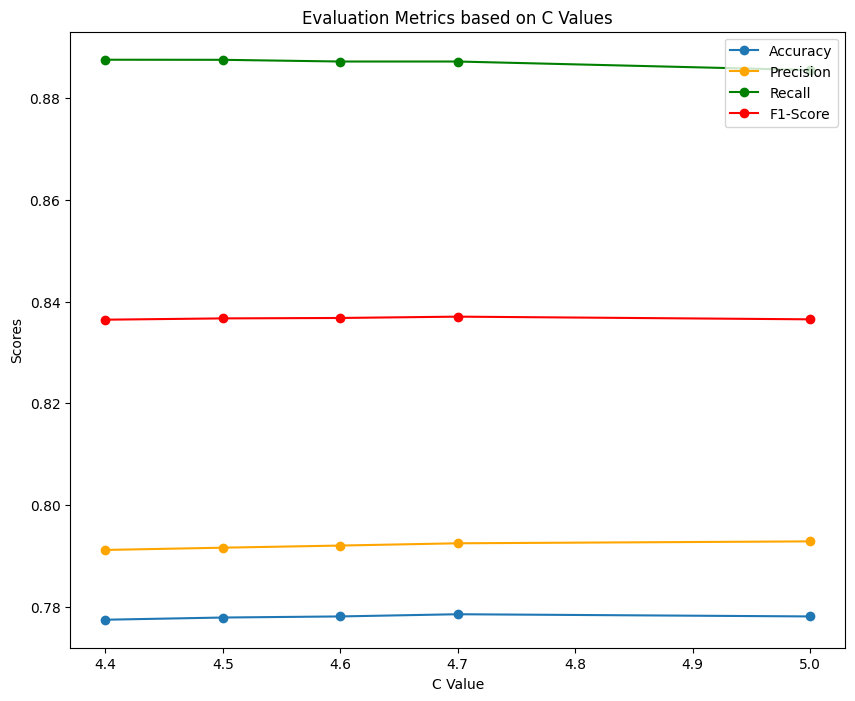

In [214]:
# Create a 2x2 subplot grid
plt.figure(figsize=(10, 8))


# Plot each metric
plt.plot(C_values, accuracies_lr, marker='o', linestyle='-', label='Accuracy')
plt.plot(C_values, precision_lr, marker='o', linestyle='-', color='orange', label='Precision')
plt.plot(C_values, recall_lr, marker='o', linestyle='-', color='green', label='Recall')
plt.plot(C_values, f1score_lr, marker='o', linestyle='-', color='red', label='F1-Score')


plt.title('Evaluation Metrics based on C Values')

plt.xlabel('C Value')
plt.ylabel('Scores')
plt.legend()

# Show the plot
# plt.tight_layout()
plt.show()

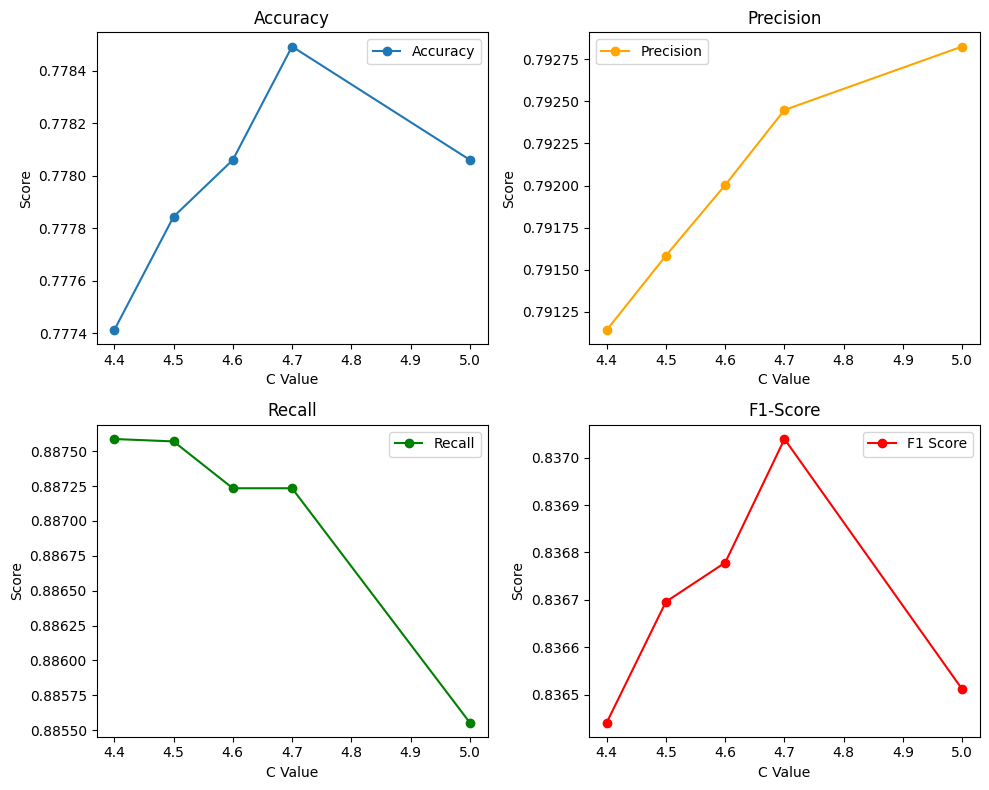

In [218]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].set_title('Accuracy')
axs[0, 1].set_title('Precision')
axs[1, 0].set_title('Recall')
axs[1, 1].set_title('F1-Score')

axs[0, 0].plot(C_values, accuracies_lr, marker='o')
axs[0, 1].plot(C_values, precision_lr, marker='o', color='orange')
axs[1, 0].plot(C_values, recall_lr, marker='o', color='green')
axs[1, 1].plot(C_values, f1score_lr, marker='o', color='red')

for ax in axs.flat:
    ax.set(xlabel='C Value', ylabel='Score')

axs[0, 0].legend(['Accuracy'])
axs[0, 1].legend(['Precision'])
axs[1, 0].legend(['Recall'])
axs[1, 1].legend(['F1 Score'])
plt.tight_layout()
plt.show()


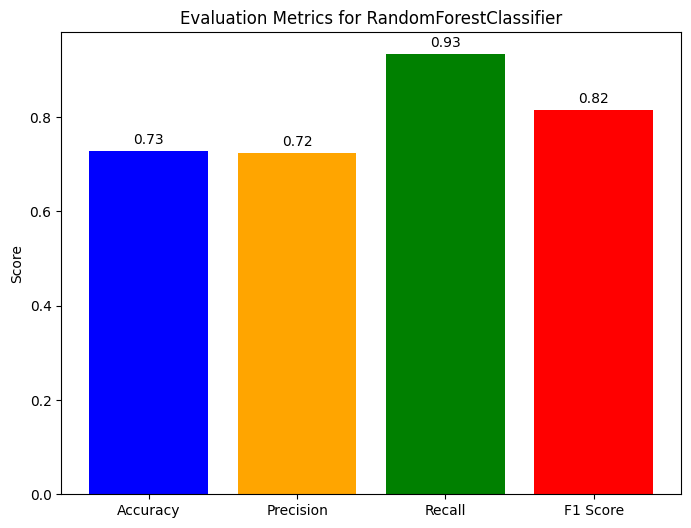

In [226]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(8, 6))
plt.bar(metrics, [accuracies_rf, precision_rf,recall_rf,f1score_rf], color=['blue', 'orange', 'green', 'red'])

plt.title('Evaluation Metrics for RandomForestClassifier')
plt.ylabel('Score')

plt.text(0, accuracies_rf + 0.015, f'{accuracies_rf:.2f}', ha='center')
plt.text(1, precision_rf + 0.015, f'{precision_rf:.2f}', ha='center')
plt.text(2, recall_rf + 0.015, f'{recall_rf:.2f}', ha='center')
plt.text(3, f1score_rf+ 0.015, f'{f1score_rf:.2f}', ha='center')

plt.show()

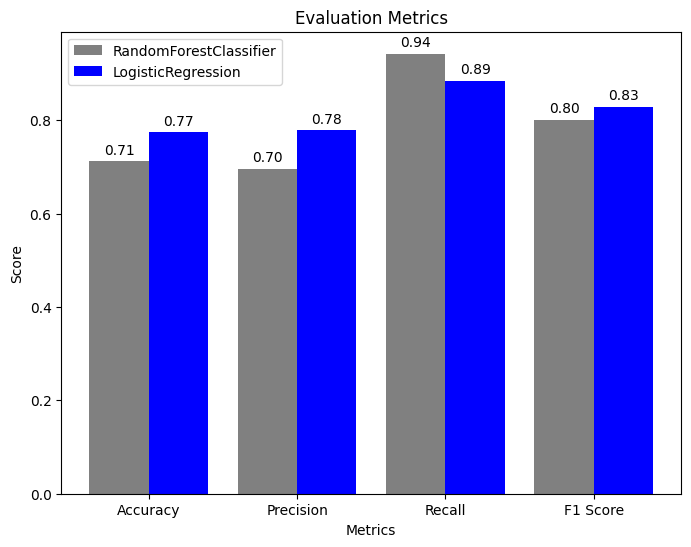

In [244]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metrics))
plt.figure(figsize=(8, 6))
plt.bar( x - 0.4/2, [accuracy_rfc, precision_rfc,recall_rfc,f1score_rfc], width=0.4, color='grey', label='RandomForestClassifier')
plt.bar(x + 0.4/2, [accuracy_sklearn, precision_sklearn,recall_sklearn,f1score_sklearn], width=0.4, color='blue', label='LogisticRegression')

plt.xticks(x, metrics)


plt.title('Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')

plt.text(x[0] - 0.4/2, accuracy_rfc + 0.015, f'{accuracy_rfc:.2f}', ha='center')
plt.text(x[1] - 0.4/2, precision_rfc + 0.015, f'{precision_rfc:.2f}', ha='center')
plt.text(x[2] - 0.4/2, recall_rfc + 0.015, f'{recall_rfc:.2f}', ha='center')
plt.text(x[3] - 0.4/2, f1score_rfc+ 0.015, f'{f1score_rfc:.2f}', ha='center')

plt.text(x[0] + 0.4/2, accuracy_sklearn + 0.015, f'{accuracy_sklearn:.2f}', ha='center')
plt.text(x[1] + 0.4/2, precision_sklearn + 0.015, f'{precision_sklearn:.2f}', ha='center')
plt.text(x[2] + 0.4/2, recall_sklearn + 0.015, f'{recall_sklearn:.2f}', ha='center')
plt.text(x[3] + 0.4/2, f1score_sklearn + 0.015, f'{f1score_sklearn:.2f}', ha='center')

plt.legend()
plt.show()